In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import opticsRayTrace.rayTraceTools as rtt
import opticsRayTrace.drawing as rtd

# Zeroth, set up the minimal system

Every system needs a beginning and an end, so the minimal system has two surfaces. 

Text(0.5, 1.0, 'Minimal system, two dummy surfaces')

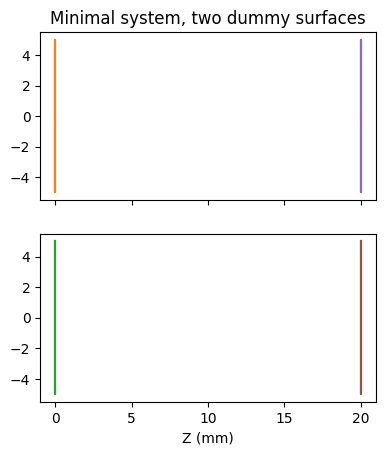

In [2]:
working_distance = 20

surface_list_1 = [
    {
        "surf": "dummy", 
        "dist": working_distance, 
        "draw_radius": 5
    },
    {
        "surf": "dummy", 
        "draw_radius": 5
    }
]

# The "geometry" takes the list of surfaces and works out their positions and
# orientations in space. Basically it adds details to the surface list, that
# will be needed by ray tracing.

geometry_1 = rtt.build_geometry(surface_list_1)

# My plotting tools are crude right now, just the ability to see X and Y
# projections of the system.

axd = rtd.new_plot_xy()
rtd.plot_faces(axd, geometry_1)
axd["axs"][0].set_title("Minimal system, two dummy surfaces")

# First, need some rays to trace

I will start with 3 rays emanating from a point. That's enough to begin having fun, and also explain some terms.

**Coordinates** are (x, y, z) with z being the typical "optical axis." The calculations work best with rays that travel roughly parallel to the z-axis, though the only strict requirement is to avoid rays that are perpendicular to the z-axis.

**Finite** system means that the light source is in a specific known location. Points on the light source can be modeled as points in space, called **field points**.

**Infinite** system means that the light source is a great distance away, effectively infinity. Instead of points on the light source, we use vectors that determine the direction of rays coming from the source, called **field vectors**. These correspond to "field angles" in the optics design packages -- vectors express angles.

**Pupil** is the location where a ray enters your optical system. Once you have a field point or vector, and a pupil point, you have specified a ray.

Text(0.5, 1.0, 'Rays diverging from entrance aperture')

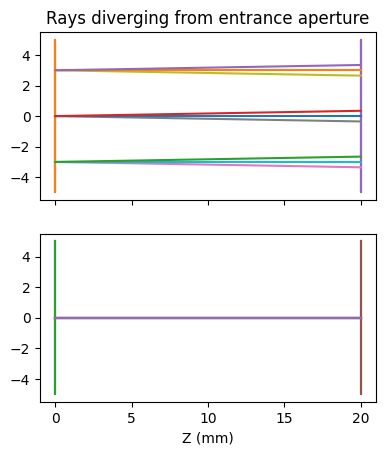

In [3]:
# Create a single field point

lsf = np.linspace(-1, 1, 3)
lsp = np.linspace(-3, 3, 3)
field_rays = np.array([np.array([np.sin(x*np.pi/180), 0, np.cos(x*np.pi/180)]) for x in lsf])
pupil_points = np.array([np.array([x, 0, 0]) for x in lsp])
wavelengths = np.array([0.000633])

# "Ray table" is a table that records the progress of each ray through the geometry. We start
# by creating an empty ray table that puts all of the surfaces in their correct locations.
# Remember, we already have "geometry" from above.

ray_table_1 = rtt.new_ray_table(geometry_1, field_rays, pupil_points, wavelengths, infinite = True)
rtt.propagate_ray(ray_table_1, geometry_1)
axd = rtd.new_plot_xy()
rtd.plot_faces(axd, geometry_1)
rtd.plot_rays(axd, geometry_1, ray_table_1, marker = '.')
axd["axs"][0].set_title("Rays diverging from entrance aperture")

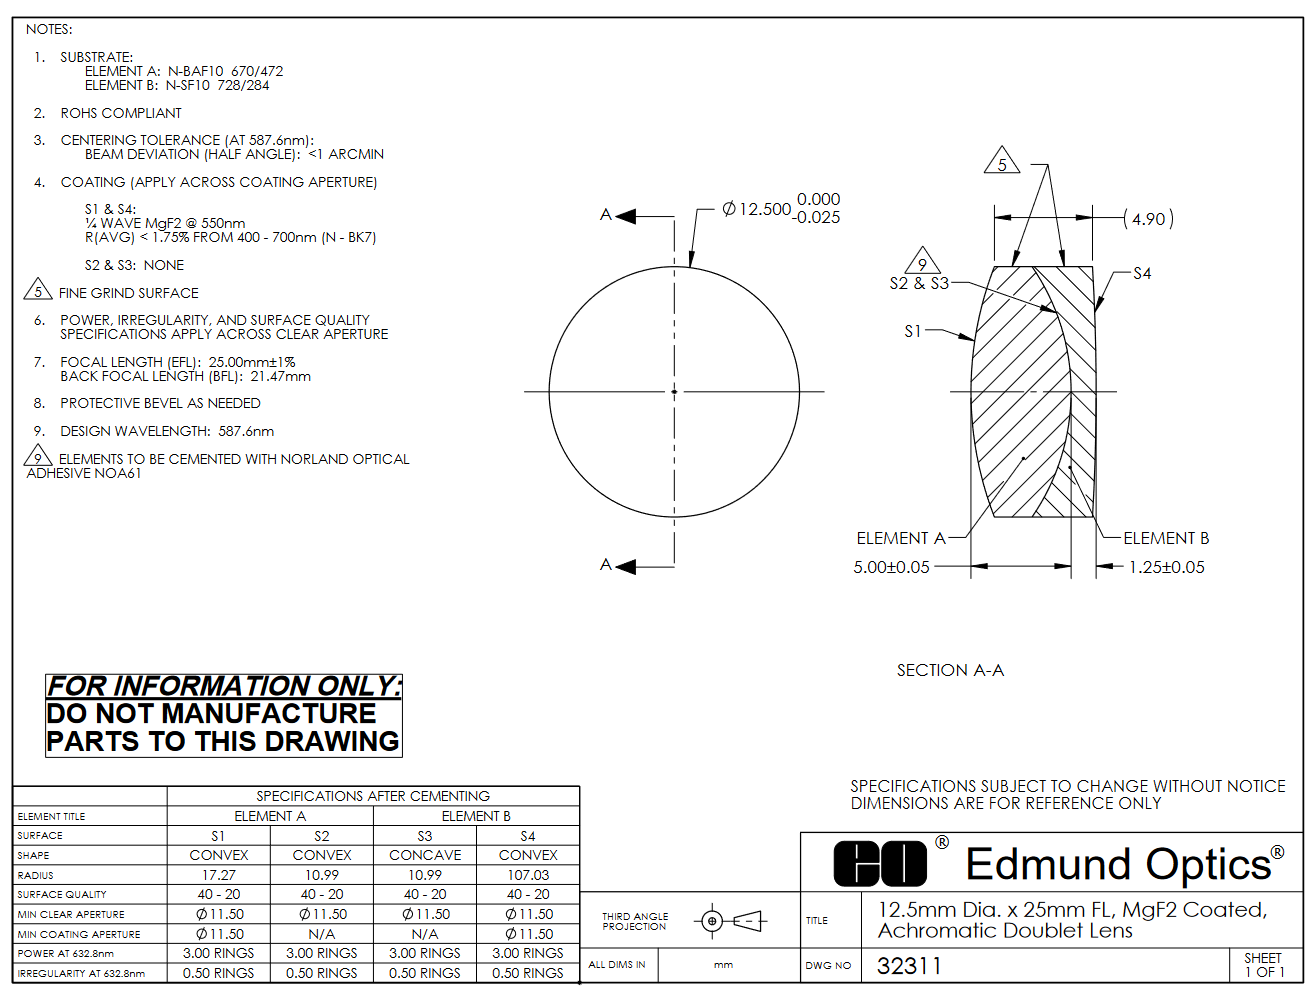

Text(0.5, 1.0, 'Edmund 32311 achromatic doublet lens')

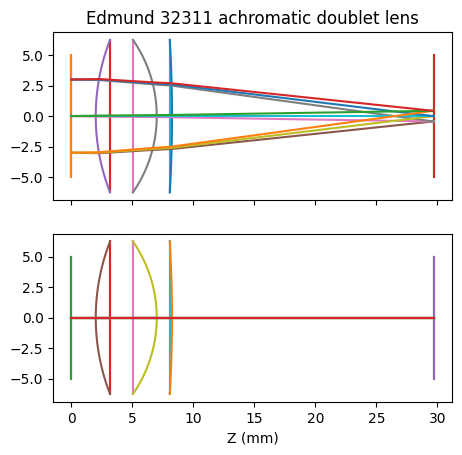

In [4]:
working_distance = 2

surface_list_2 = [
    {
        "surf": "dummy", 
        "dist": working_distance, 
        "draw_radius": 5
    },
    {
        "surf": "conic",
        "c": 1/17.27,
        "k": 0,
        "dist": 5,
        "material": "N-BAF10",
        "draw_radius": 6.26
    },
    {
        "surf": "conic",
        "c": -1/10.99,
        "k": 0,
        "dist": 1.25,
        "material": "N-SF10",
        "draw_radius": 6.26
    },
    {
        "surf": "conic",
        "c": -1/107.03,
        "k": 0,
        "dist": 21.47,
        "draw_radius": 6.26
    },
    {
        "surf": "dummy", 
        "draw_radius": 5
    }
]

geometry_2 = rtt.build_geometry(surface_list_2)

lsf = np.linspace(-1, 1, 3)
lsp = np.linspace(-3, 3, 3)
field_rays = np.array([np.array([x*np.pi/180, 0, 1]) for x in lsf])
pupil_points = np.array([np.array([x, 0, 0]) for x in lsp])
wavls = np.array([0.000633])

# "Ray table" is a table that records the progress of each ray through the geometry. We start
# by creating an empty ray table that puts all of the surfaces in their correct locations.
# Remember, we already have "geometry" from above.

ray_table_2 = rtt.new_ray_table(geometry_2, field_rays, pupil_points, wavelengths, infinite = True)
rtt.propagate_ray(ray_table_2, geometry_2)
axd = rtd.new_plot_xy()
rtd.plot_faces(axd, geometry_2)
rtd.plot_rays(axd, geometry_2, ray_table_2, marker = '.')
axd["axs"][0].set_title("Edmund 32311 achromatic doublet lens")
